In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
import csv
from torch.utils.data import DataLoader
from datetime import datetime  # 用于计算时间

In [2]:
class My_dataset():
    def __init__(self,data_feature,data_label):
        super().__init__()
        # 读取的样本装入self.src,目标值装入self.trg
        self.src = torch.tensor(data_feature)
        self.trg = torch.tensor(data_label)
        
    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)

In [3]:
# 首先遍历读入每个样本，结构为[帧数*特征数]的DataFrame
# 然后把每个样本装入feature中，结构为list；同时对应记录下目标值，装入label中
# 统一装入list之后，随机划分训练集/测试集

feature,label = [],[]
#疲劳等级为[0,3)
for labelIndex in range(0,3):
    y = labelIndex
    sampleNum = 0
    if labelIndex == 0:
        sampleNum = 199
    elif labelIndex == 1:
        sampleNum = 90
    else:
        sampleNum = 132

    #遍历读取样本数据
    for sampleIndex in range(1,sampleNum + 1):
        x = pd.read_csv("../data_final/level_"+ str(labelIndex) + "/" + str(labelIndex)+"_" + str(sampleIndex) + ".csv")        
        x.drop(x.columns[[0]],axis = 1,inplace=True)
        x.drop(x.columns[[0]],axis = 1,inplace=True)
        # 把每个样本装入feature中
        feature.append(x)
        label.append(y)

In [4]:
import random
from sklearn.preprocessing import StandardScaler
# 现在划分训练集：验证集：测试集 = 8：1：1
train_feature,train_label,valid_feature,valid_label,test_feature,test_label = [],[],[],[],[],[]
# 特征工程：标准化
standard_transfer = StandardScaler()

for index in range (0,421):
    sampleFeature = feature[index]
    sampleLabel = label[index]
    # 生成第一个随机数
    randNum = random.random()
    # 如果生成的随机数小于0.8，则作为训练集；剩余的作为测试集
    if randNum < 0.8:
        sampleFeature = standard_transfer.fit_transform(sampleFeature)
        train_feature.append(sampleFeature.tolist())
        train_label.append(sampleLabel)
    elif randNum >=0.9:
        sampleFeature = standard_transfer.transform(sampleFeature)
        test_feature.append(sampleFeature.tolist())
        test_label.append(sampleLabel)
    else:
        sampleFeature = standard_transfer.fit_transform(sampleFeature)
        valid_feature.append(sampleFeature.tolist())
        valid_label.append(sampleLabel)

In [5]:
# 定义常量
INPUT_SIZE = 2  # 定义输入的特征数
HIDDEN_SIZE = 32    # 定义一个LSTM单元有多少个神经元
BATCH_SIZE = 32   # batch
EPOCH = 15    # 学习次数
LR = 0.001   # 学习率
TIME_STEP = 30   # 步长
DROP_RATE = 0.1    #  drop out概率
LAYERS = 2         # 有多少隐层，一个隐层一般放一个LSTM单元
MODEL = 'LSTM'     # 模型名字

In [6]:
train_data = My_dataset(train_feature,train_label)
valid_data = My_dataset(valid_feature,valid_label)
test_data = My_dataset(test_feature,test_label)

# # i_batch的多少根据batch size和def __len__(self)返回的长度确定
# # batch_data返回的值根据def __getitem__(self, index)来确定
# # 对训练集：
# for i_batch, batch_data in enumerate(train_data):
#     print(i_batch)  # 打印batch编号
#     print(batch_data[0])  # 打印该batch里面src
#     print(batch_data[1])  # 打印该batch里面trg
# # 对测试集：
# for i_batch, (src, trg) in enumerate(test_data):
#     print(i_batch)  # 打印batch编号
#     print(src)  # 打印该batch里面src的尺寸
#     print(trg)  # 打印该batch里面trg的尺寸    

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE,pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE,pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE,pin_memory=True, shuffle=False)

In [7]:
# 定义LSTM的结构
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size = INPUT_SIZE, 
            hidden_size = HIDDEN_SIZE, 
            num_layers = LAYERS,
            dropout = DROP_RATE,
            batch_first = True    # 如果为True，输入输出数据格式是(batch, seq_len, feature)
                                  # 为False，输入输出数据格式是(seq_len, batch, feature)，
        )
        self.hidden_out = nn.Linear(HIDDEN_SIZE, 15)  # 最后一个时序的输出接一个全连接层
        self.h_s = None
        self.h_c = None
        
    def forward(self, x):    # x是输入数据集
        r_out, (h_s, h_c) = self.rnn(x)   # 如果不导入h_s和h_c，默认每次都进行0初始化
                                          #  h_s和h_c表示每一个隐层的上一时间点输出值和输入细胞状态
                                          # h_s和h_c的格式均是(num_layers * num_directions, batch, HIDDEN_SIZE)
                                          # 如果是双向LSTM，num_directions是2，单向是1
        output = self.hidden_out(r_out)
        return output

In [8]:
# 设置GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
# 设置随机种子
torch.manual_seed(0)

In [9]:
rnn = lstm().to(device)    # 使用GPU或CPU
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss() # 分类问题

# 定义学习率衰减点，训练到50%和75%时学习率缩小为原来的1/10
mult_step_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                             milestones=[EPOCH//2, EPOCH//4*3], gamma=0.1)

# 训练+验证
train_loss = []
valid_loss = []
train_loss_list,valid_loss_list,index=[],[],[]
min_valid_loss = np.inf
for i in range(EPOCH):
    total_train_loss = []    
    rnn.train()   # 进入训练模式
    for step, (b_x, b_y) in enumerate(train_loader):
#         lr = set_lr(optimizer, i, EPOCH, LR)
        b_x = b_x.type(torch.FloatTensor).to(device)
        b_y = b_y.type(torch.long).to(device)   # CrossEntropy的target是longtensor，且要是1-D，不是one hot编码形式
        prediction = rnn(b_x) # rnn output
        loss = loss_func(prediction[:, -1, :], b_y.view(b_y.size()[0]))         # 计算损失，target要转1-D，注意b_y不是one hot编码形式        
        optimizer.zero_grad()                   # clear gradients for this training step
        loss.backward()                         # backpropagation, compute gradients
        optimizer.step()                        # apply gradients
        total_train_loss .append(loss.item())
    train_loss.append(np.mean(total_train_loss )) # 存入平均交叉熵
    
    total_valid_loss = [] 
    rnn.eval()
    for step, (b_x, b_y) in enumerate(valid_loader):
        b_x = b_x.type(torch.FloatTensor).to(device) 
        b_y = b_y.type(torch.long).to(device) 
        with torch.no_grad():
            prediction = rnn(b_x) # rnn output
        loss = loss_func(prediction[:, -1, :], b_y.view(b_y.size()[0]))         # calculate loss        
        total_valid_loss.append(loss.item())        
    valid_loss.append(np.mean(total_valid_loss))
    
    if (valid_loss[-1] < min_valid_loss):      
        torch.save({'epoch': i, 'model': rnn, 'train_loss': train_loss,
                'valid_loss': valid_loss},'./LSTM.model') # 保存字典对象，里面'model'的value是模型  
        min_valid_loss = valid_loss[-1]
    temp = pd.read_csv('./loss.csv')
    index.append(i+temp.shape[0])
    train_loss_list.append(train_loss[-1])
    valid_loss_list.append(valid_loss[-1])
    mult_step_scheduler.step()  # 学习率更新

data = {
    "index":index,
    "train_loss": train_loss_list,
    "valid_loss": valid_loss_list
}
loss = pd.DataFrame(data)
#loss.to_csv('./loss.csv')


with open('./loss.csv',mode='a',newline='',encoding='utf8') as cfa:
    wf = csv.writer(cfa)
    for i in range(0,15):
        wf.writerow(loss.loc[i])

[[13  0  0]
 [ 6  0  0]
 [15  0  0]]
accuracy: 0.38235294117647056


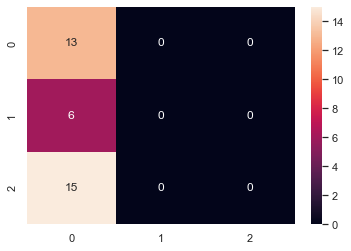

In [10]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

best_model = torch.load('./LSTM.model').get('model')
best_model.eval()
final_predict = []
ground_truth = []

for step, (b_x, b_y) in enumerate(test_loader):
    b_x = b_x.type(torch.FloatTensor).to(device) 
    b_y = b_y.type(torch.long).to(device) 

    with torch.no_grad():
        prediction = best_model(b_x) # rnn output
    
    loss = loss_func(prediction[:, -1, :], b_y.view(b_y.size()[0]))          # calculate loss
    
    ground_truth = ground_truth + b_y.view(b_y.size()[0]).cpu().numpy().tolist()
    final_predict = final_predict + torch.max(prediction[:, -1, :], 1)[1].cpu().data.numpy().tolist()

ground_truth = np.asarray(ground_truth)
final_predict = np.asarray(final_predict)

accuracy = float((ground_truth == final_predict).astype(int).sum()) / float(final_predict.size)

#生成混淆矩阵
sns.set()
f,ax = plt.subplots()
y_true = ground_truth
y_pred = final_predict
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2])
print(C2)
sns.heatmap(C2,annot=True,ax=ax) #画热力图
# ax.set_titile('confusion matrix') #标题
# ax.set_xlabel('predict') #x 轴
# ax.set_ylabel('true') #y 轴


# 准确度
print("accuracy:",accuracy)
# accuracy_list = []
# accuracy_list.append(accuracy)
# data = {
#     "index":pd.read_csv('./accuracy.csv').shape[0],
#     "accuracy":accuracy_list
# }
# accuracy_pd = pd.DataFrame(data)

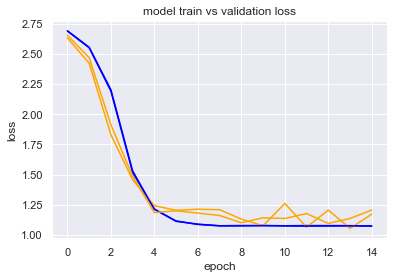

In [11]:
loss = pd.read_csv("./loss.csv")
loss.drop(loss.columns[[0]],axis = 1,inplace=True)
pd.DataFrame(loss)
train_loss,valid_loss=[],[] 
train_loss_list,valid_loss_list=[],[]
for i in range(0,loss.shape[0],15):
    for j in range(0,15):
        train_loss.append(loss.iloc[i+j].at['train_loss'])
        valid_loss.append(loss.iloc[i+j].at['valid_loss'])
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
    plt.plot(train_loss, color='blue', label='train_loss')
    plt.plot(valid_loss, color='orange', label='valid_loss')
    train_loss=[]
    valid_loss=[]
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()